In [1]:
# Import.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_wine
import importlib
rf = importlib.import_module("random-forests")

# Load datasets.
X_iris, y_iris = load_iris(return_X_y=True)  # feature_type="continuous"
X_wine, y_wine = load_wine(return_X_y=True)  # feature_type="continuous"
mushroom = np.genfromtxt("agaricus-lepiota.data", delimiter=",", dtype=str)
X_mushroom = mushroom[:, 1:]  # feature_type="categorical"
y_mushroom = mushroom[:, 0]
breast_cancer = np.genfromtxt("breast-cancer.data", delimiter=",", dtype=str)
breast_cancer = breast_cancer[(breast_cancer != "?").all(axis=1), :]
X_breast_cancer = breast_cancer[:, 1:]  # feature_type="categorical"
y_breast_cancer = breast_cancer[:, 0]
heart_disease = np.genfromtxt("processed.cleveland.data", delimiter=",")
heart_disease = heart_disease[~np.isnan(heart_disease).any(axis=1), :]
X_heart_disease = heart_disease[:, :13]  # feature_type="categorical"
y_heart_disease = heart_disease[:, 13]
y_heart_disease[np.where(y_heart_disease >= 1)] = 1
titanic = pd.read_csv("titanic.csv").drop(columns=["PassengerId", "Name", "Ticket", "Cabin"]).dropna()
X_titanic = titanic.loc[:, titanic.columns!="Survived"].to_numpy()  # feature_type: complex
y_titanic = titanic["Survived"].to_numpy()

In [2]:
# train_test_split(X, y) -> X_train, X_test, y_train, y_test
ftype_h_d = np.array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1])
feature_type_titanic = np.ones(7)
feature_type_titanic[2] = 0  # Age
feature_type_titanic[5] = 0  # Fare
datasets = {
    "iris": (*train_test_split(X_iris, y_iris, stratify=y_iris), "continuous"),
    "wine": (*train_test_split(X_wine, y_wine, stratify=y_wine), "continuous"),
    # "mushroom (categorical)": (*train_test_split(X_mushroom, y_mushroom, stratify=y_mushroom), "categorical"),
    "breast_cancer": (*train_test_split(X_breast_cancer, y_breast_cancer, stratify=y_breast_cancer), "categorical"),
    "heart_disease": (*train_test_split(X_heart_disease, y_heart_disease, stratify=y_heart_disease), ftype_h_d),
    "titanic": (*train_test_split(X_titanic, y_titanic, stratify=y_titanic), feature_type_titanic),
}
cmap = {"iris": "blue", "wine": "purple", "heart_disease": "red", "breast_cancer": "orange", "titanic": "green"}

**Breiman**
- RF accuracy depends on individual tree **strength** and **correlation**
- **LLN** guarantees the generalisation error converges a.s. as `n_trees` increases,<br>
  so that overfitting is not a problem

In [3]:
# Test varying `n_trees`.
n_trees = np.arange(1, 21)
n_exp=5  # Number of experiments.
error_rates_mean = np.ones((len(datasets.keys()), len(n_trees)))
error_rates_std = np.zeros((len(datasets.keys()), len(n_trees)))
for dataset_idx, dataset in enumerate(datasets.keys()):
    X_train, X_test, y_train, y_test, feature_type= datasets[dataset]
    n_features = X_train.shape[1]
    n_c = int(np.sqrt(n_features))
    # m = int(np.sqrt(len(np.unique(y_train))))
    for n in n_trees:
        random_forest = rf.RandomForest(
            n_trees=n, max_depth=100, min_leaf_size=1, n_candidates=n_c, criterion="gini")
        error_rate = np.ones(n_exp)
        for i in range(n_exp):
            random_forest.fit(X_train, y_train, feature_type, m_features=2)
            y_predicted = random_forest.predict(X_test)
            error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
        error_rates_mean[dataset_idx, n-1] = error_rate.mean()
        error_rates_std[dataset_idx, n-1] = error_rate.std()

np.savez("test_n.npz", mean=error_rates_mean, std=error_rates_std)

In [5]:
# Test varying `n_trees` using ImprovedRandomForest.
n_trees = np.arange(1, 21)
n_exp=5  # Number of experiments.
error_rates_mean = np.ones((len(datasets.keys()), len(n_trees)))
error_rates_std = np.zeros((len(datasets.keys()), len(n_trees)))
for dataset_idx, dataset in enumerate(datasets.keys()):
    X_train, X_test, y_train, y_test, feature_type= datasets[dataset]
    n_features = X_train.shape[1]
    n_c = int(np.sqrt(n_features))
    # m = int(np.sqrt(len(np.unique(y_train))))
    for n in n_trees:
        random_forest = rf.ImprovedRandomForest(
            n_trees=n, max_depth=100, min_leaf_size=1, n_candidates=n_c, criterion="gini")
        error_rate = np.ones(n_exp)
        for i in range(n_exp):
            random_forest.fit(X_train, y_train, feature_type, m_features=2)
            y_predicted = random_forest.predict(X_test)
            error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
        error_rates_mean[dataset_idx, n-1] = error_rate.mean()
        error_rates_std[dataset_idx, n-1] = error_rate.std()

np.savez("test_n_improved.npz", mean=error_rates_mean, std=error_rates_std)

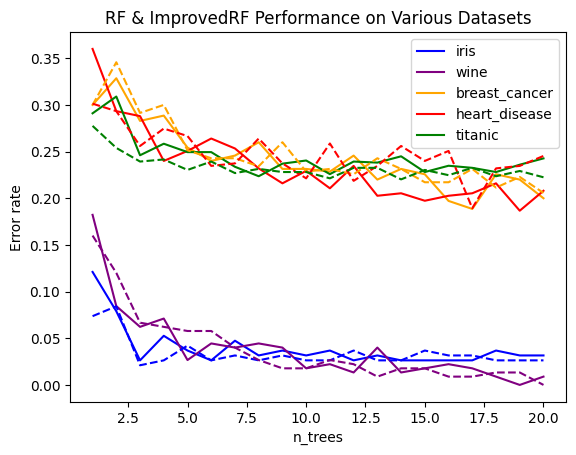

In [69]:
n_trees = np.arange(1, 21)
n_exp=5

error_rates = np.load("test_n.npz")
error_rates_mean = error_rates["mean"]
error_rates_std = error_rates["std"]
for dataset_idx, dataset in enumerate(datasets.keys()):
    plt.plot(n_trees, error_rates_mean[dataset_idx, :],
                 # yerr=error_rates_std[dataset_idx, :]/np.sqrt(n_exp),
                 label=dataset, color=cmap[dataset]
                 )

error_rates = np.load("test_n_improved.npz")
error_rates_mean = error_rates["mean"]
error_rates_std = error_rates["std"]
for dataset_idx, dataset in enumerate(datasets.keys()):
    plt.plot(n_trees, error_rates_mean[dataset_idx, :],
                 # yerr=error_rates_std[dataset_idx, :]/np.sqrt(n_exp),
                 "--", color=cmap[dataset]
                 )
plt.xlabel("n_trees")
plt.ylabel("Error rate")
plt.title("RF & ImprovedRF Performance on Various Datasets")
plt.legend()

In [ ]:
n_trees = np.arange(1, 21)
n_exp=5

error_rates = np.load("test_n.npz")
mean_rf = error_rates["mean"]
std_rf = error_rates["std"]
error_rates = np.load("test_n_improved.npz")
mean_irf = error_rates["mean"]
std_irf = error_rates["std"]
ys = mean_rf - mean_irf
yerr = std_rf + std_irf

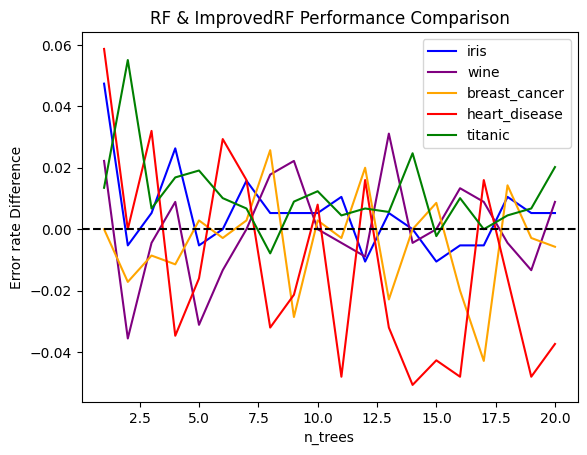

In [20]:
n_trees = np.arange(1, 21)
n_exp=5

error_rates = np.load("test_n.npz")
mean_rf = error_rates["mean"]
std_rf = error_rates["std"]
error_rates = np.load("test_n_improved.npz")
mean_irf = error_rates["mean"]
std_irf = error_rates["std"]
ys = mean_rf - mean_irf
yerr = std_rf + std_irf
for dataset_idx, dataset in enumerate(datasets.keys()):
    plt.plot(n_trees, ys[dataset_idx, :],
                 # yerr=yerr[dataset_idx, :]/np.sqrt(n_exp),
                 label=dataset, color=cmap[dataset]
                 )
plt.axhline(y=0, color="k", linestyle="--")
plt.xlabel("n_trees")
plt.ylabel("Error rate Difference")
plt.title("RF & ImprovedRF Performance Comparison")
plt.legend()

In [21]:
# Test RF performance on the Titanic dataset.
X_train, X_test, y_train, y_test, feature_type= datasets["titanic"]
n_trees = np.arange(1, 51)
n_exp=5
error_rates_mean = np.ones(len(n_trees))
error_rates_std = np.zeros(len(n_trees))
for n in n_trees:
    random_forest = rf.RandomForest(n_trees=n, n_candidates=2)
    error_rate = np.ones(n_exp)
    for i in range(n_exp):
        random_forest.fit(X_train, y_train, feature_type, m_features=2)
        y_predicted = random_forest.predict(X_test)
        error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
    error_rates_mean[n-1] = error_rate.mean()
    error_rates_std[n-1] = error_rate.std()
np.savez("test_titanic_n50.npz", mean=error_rates_mean, std=error_rates_std)

In [70]:
# Test RF performance on the Heart Disease dataset.
X_train, X_test, y_train, y_test, feature_type= datasets["heart_disease"]
n_trees = np.arange(1, 51)
n_exp=5
error_rates_mean = np.ones(len(n_trees))
error_rates_std = np.zeros(len(n_trees))
for n in n_trees:
    random_forest = rf.RandomForest(n_trees=n, n_candidates=3)
    error_rate = np.ones(n_exp)
    for i in range(n_exp):
        random_forest.fit(X_train, y_train, feature_type, m_features=2)
        y_predicted = random_forest.predict(X_test)
        error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
    error_rates_mean[n-1] = error_rate.mean()
    error_rates_std[n-1] = error_rate.std()
np.savez("test_heart_n50.npz", mean=error_rates_mean, std=error_rates_std)

In [22]:
# Test IRF performance on the Titanic dataset.
X_train, X_test, y_train, y_test, feature_type= datasets["titanic"]
n_trees = np.arange(1, 51)
n_exp=5
error_rates_mean = np.ones(len(n_trees))
error_rates_std = np.zeros(len(n_trees))
for n in n_trees:
    random_forest = rf.ImprovedRandomForest(n_trees=n, n_candidates=2)
    error_rate = np.ones(n_exp)
    for i in range(n_exp):
        random_forest.fit(X_train, y_train, feature_type, m_features=2)
        y_predicted = random_forest.predict(X_test)
        error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
    error_rates_mean[n-1] = error_rate.mean()
    error_rates_std[n-1] = error_rate.std()
np.savez("test_irf_titanic_n50.npz", mean=error_rates_mean, std=error_rates_std)

In [71]:
# Test IRF performance on the Heart Disease dataset.
X_train, X_test, y_train, y_test, feature_type= datasets["heart_disease"]
n_trees = np.arange(1, 51)
n_exp=5
error_rates_mean = np.ones(len(n_trees))
error_rates_std = np.zeros(len(n_trees))
for n in n_trees:
    random_forest = rf.ImprovedRandomForest(n_trees=n, n_candidates=3)
    error_rate = np.ones(n_exp)
    for i in range(n_exp):
        random_forest.fit(X_train, y_train, feature_type, m_features=2)
        y_predicted = random_forest.predict(X_test)
        error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
    error_rates_mean[n-1] = error_rate.mean()
    error_rates_std[n-1] = error_rate.std()
np.savez("test_irf_heart_n50.npz", mean=error_rates_mean, std=error_rates_std)

Text(0.5, 0.98, 'RF & ImprovedRF Performance on the Titanic Dataset')

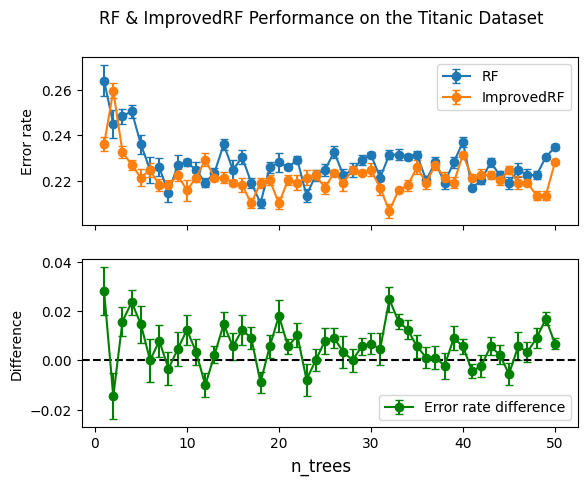

In [68]:
n_trees = np.arange(1, 51)
n_exp=5

error_rates = np.load("test_titanic_n50.npz")
mean_rf = error_rates["mean"]
std_rf = error_rates["std"]
error_rates = np.load("test_irf_titanic_n50.npz")
mean_irf = error_rates["mean"]
std_irf = error_rates["std"]
mean_diff = mean_rf - mean_irf
std_diff = std_rf + std_irf

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].errorbar(n_trees, mean_rf,
               yerr=std_rf/n_exp,
               label="RF", capsize=3, fmt="o-"
)
ax[0].errorbar(n_trees, mean_irf,
               yerr=std_irf/n_exp,
               label="ImprovedRF", capsize=3, fmt="o-"
)
ax[1].errorbar(n_trees, mean_diff,
               yerr=std_diff/n_exp,
               label="Error rate difference", capsize=3, fmt="o-", color="g"
)
ax[1].axhline(y=0, color="k", linestyle="--")
ax[0].set(ylabel="Error rate")
ax[1].set(ylabel="Difference")
ax[0].legend()
ax[1].legend()
fig.supxlabel("n_trees")
fig.suptitle("RF & ImprovedRF Performance on the Titanic Dataset")

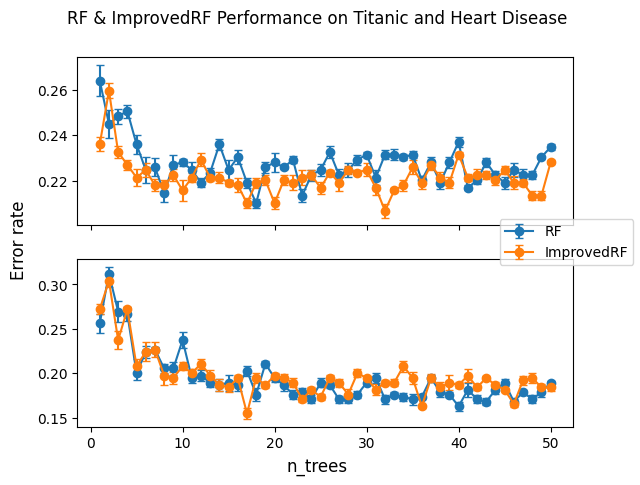

In [75]:
n_trees = np.arange(1, 51)
n_exp=5

error_rates = np.load("test_titanic_n50.npz")
mean_titanic_rf = error_rates["mean"]
std_titanic_rf = error_rates["std"]
error_rates = np.load("test_irf_titanic_n50.npz")
mean_titanic_irf = error_rates["mean"]
std_titanic_irf = error_rates["std"]

error_rates = np.load("test_heart_n50.npz")
mean_heart_rf = error_rates["mean"]
std_heart_rf = error_rates["std"]
error_rates = np.load("test_irf_heart_n50.npz")
mean_heart_irf = error_rates["mean"]
std_heart_irf = error_rates["std"]

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].errorbar(n_trees, mean_titanic_rf,
               yerr=std_titanic_rf/n_exp,
               label="RF", capsize=3, fmt="o-"
)
ax[0].errorbar(n_trees, mean_titanic_irf,
               yerr=std_titanic_irf/n_exp,
               label="ImprovedRF", capsize=3, fmt="o-"
)
ax[1].errorbar(n_trees, mean_heart_rf,
               yerr=std_heart_rf/n_exp,
               capsize=3, fmt="o-"
)
ax[1].errorbar(n_trees, mean_heart_irf,
               yerr=std_heart_irf/n_exp,
               capsize=3, fmt="o-"
)
fig.supxlabel("n_trees")
fig.supylabel("Error rate")
fig.suptitle("RF & ImprovedRF Performance on Titanic and Heart Disease")
fig.legend(loc="center right")

Text(0.5, 0.98, 'RF & ImprovedRF Performance on Titanic and Heart Disease')

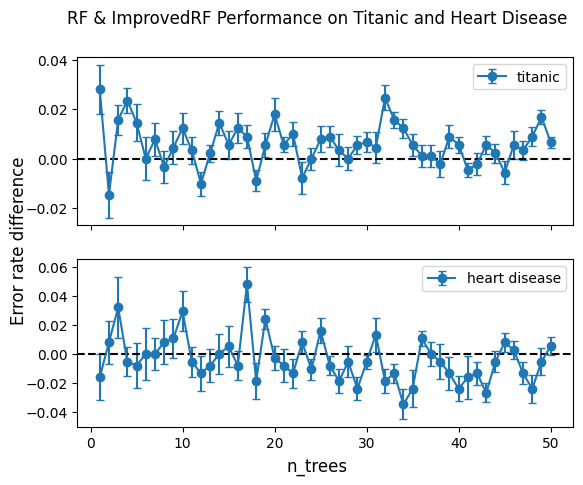

In [77]:
titanic_diff = mean_titanic_rf - mean_titanic_irf
titanic_diff_std = std_titanic_rf + std_titanic_irf
heart_diff = mean_heart_rf - mean_heart_irf
heart_diff_std = std_heart_rf + std_heart_irf

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].errorbar(n_trees, titanic_diff,
               yerr=titanic_diff_std/n_exp,
               label="titanic", capsize=3, fmt="o-"
)
ax[1].errorbar(n_trees, heart_diff,
               yerr=heart_diff_std/n_exp,
               label="heart disease", capsize=3, fmt="o-"
)
ax[0].axhline(y=0, color="k", linestyle="--")
ax[1].axhline(y=0, color="k", linestyle="--")
ax[0].legend()
ax[1].legend()
fig.supxlabel("n_trees")
fig.supylabel("Error rate difference")
fig.suptitle("RF & ImprovedRF Performance on Titanic and Heart Disease")

In [7]:
# Test varing `n_trees` with different `m_features` on the Titanic dataset.
X_train, X_test, y_train, y_test, feature_type= datasets["titanic (complex)"]
n_trees = np.arange(1, 31)
m_features = [1, 2, 3]
n_exp=3
error_rates_mean = np.ones((len(m_features), len(n_trees)))
error_rates_std = np.zeros((len(m_features), len(n_trees)))
for n in n_trees:
    for m in m_features:
        random_forest = rf.RandomForest(
            n_trees=n, max_depth=100, min_leaf_size=1, n_candidates=2, criterion="gini")
        error_rate = np.ones(n_exp)
        for i in range(n_exp):
            random_forest.fit(X_train, y_train, feature_type, m_features=m)
            y_predicted = random_forest.predict(X_test)
            error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
        error_rates_mean[m_features.index(m), n-1] = error_rate.mean()
        error_rates_std[m_features.index(m), n-1] = error_rate.std()

np.savez("test_titanic_n30_m.npz", mean=error_rates_mean, std=error_rates_std)

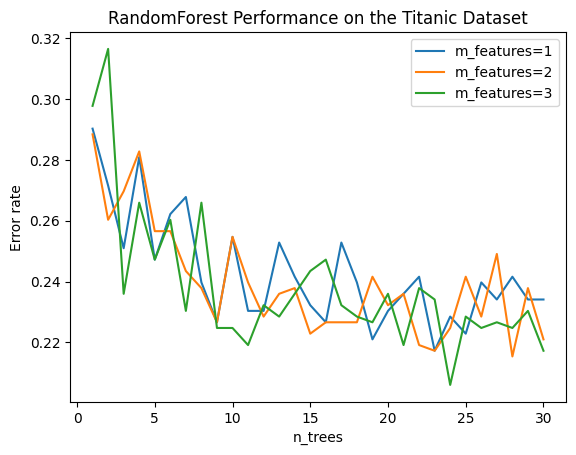

In [8]:
error_rates = np.load("test_titanic_n30_m.npz")
error_rates_mean = error_rates["mean"]
error_rates_std = error_rates["std"]
n_trees = np.arange(1, 31)
m_features = [1, 2, 3]
n_exp=3
for m in m_features:
    # plt.errorbar(n_trees, error_rates_mean[m_features.index(m), :],
    #                 yerr=error_rates_std[m_features.index(m), :]/np.sqrt(n_exp),
    #                 label=f"m_features={m}", capsize=3, fmt=".-"
    #                 )
    plt.plot(n_trees, error_rates_mean[m_features.index(m), :],
             label=f"m_features={m}")
plt.xlabel("n_trees")
plt.ylabel("Error rate")
plt.title("RandomForest Performance on the Titanic Dataset")
plt.legend()

**Breiman**
- RF performance is *insensitive* to the number of features selected to split each node.
- Usually `m_features=1` or `m_features=2` gives near optimum results

In [9]:
# Test varing `n_trees` with different `m_features` on the Breast Cancer dataset.
X_train, X_test, y_train, y_test, feature_type= datasets["breast_cancer (categorical)"]
n_trees = np.arange(1, 31)
m_features = [1, 2, 3]
n_exp=3
error_rates_mean = np.ones((len(m_features), len(n_trees)))
error_rates_std = np.zeros((len(m_features), len(n_trees)))
for n in n_trees:
    for m in m_features:
        random_forest = rf.RandomForest(
            n_trees=n, max_depth=100, min_leaf_size=1, n_candidates=3, criterion="gini")
        error_rate = np.ones(n_exp)
        for i in range(n_exp):
            random_forest.fit(X_train, y_train, feature_type, m_features=m)
            y_predicted = random_forest.predict(X_test)
            error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
        error_rates_mean[m_features.index(m), n-1] = error_rate.mean()
        error_rates_std[m_features.index(m), n-1] = error_rate.std()

np.savez("test_breast_cancer_n30_m.npz", mean=error_rates_mean, std=error_rates_std)

In [11]:
# Test varing `n_trees` with different `m_features` on the Breast Cancer dataset
# using ImprovedRandomForest
X_train, X_test, y_train, y_test, feature_type= datasets["breast_cancer (categorical)"]
n_trees = np.arange(1, 31)
m_features = [1, 2, 3]
n_exp=3
error_rates_mean = np.ones((len(m_features), len(n_trees)))
error_rates_std = np.zeros((len(m_features), len(n_trees)))
for n in n_trees:
    for m in m_features:
        random_forest = rf.ImprovedRandomForest(
            n_trees=n, max_depth=100, min_leaf_size=1, n_candidates=3, criterion="gini")
        error_rate = np.ones(n_exp)
        for i in range(n_exp):
            random_forest.fit(X_train, y_train, feature_type, m_features=m)
            y_predicted = random_forest.predict(X_test)
            error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
        error_rates_mean[m_features.index(m), n-1] = error_rate.mean()
        error_rates_std[m_features.index(m), n-1] = error_rate.std()

np.savez("test_breast_cancer_n30_m_improved.npz", mean=error_rates_mean, std=error_rates_std)

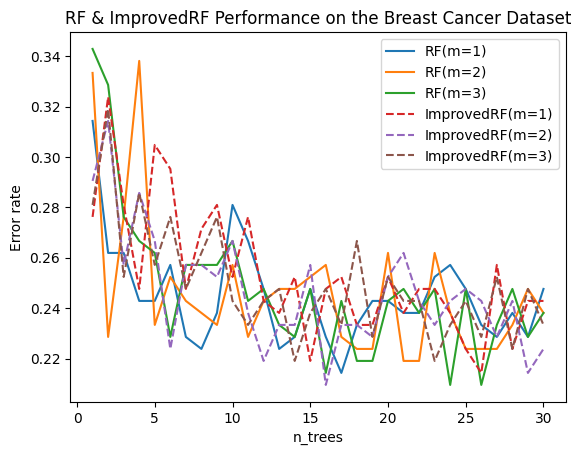

In [7]:
n_trees = np.arange(1, 31)
m_features = [1, 2, 3]
n_exp=3

error_rates = np.load("test_breast_cancer_n30_m.npz")
error_rates_mean = error_rates["mean"]
error_rates_std = error_rates["std"]
for m in m_features:
    plt.plot(n_trees, error_rates_mean[m_features.index(m), :],
             label=f"RF(m={m})")

error_rates = np.load("test_breast_cancer_n30_m_improved.npz")
error_rates_mean = error_rates["mean"]
error_rates_std = error_rates["std"]
for m in m_features:
    plt.plot(n_trees, error_rates_mean[m_features.index(m), :],
             "--", label=f"ImprovedRF(m={m})")

plt.xlabel("n_trees")
plt.ylabel("Error rate")
plt.title("RF & ImprovedRF Performance on the Breast Cancer Dataset")
plt.legend()